In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
from Bio.Phylo._io import parse
from Bio.Phylo.BaseTree import Tree as BioTree

from src.datasets.load_trees import load_trees_from_file
from src.utils.tree_utils import get_taxa_names
from src.utils.tree_utils import get_tree_height
from src.distribution_analysis.process_tree import get_observed_nodes, get_clade_split_df

from scipy.stats import ks_2samp

from collections import Counter

In [91]:

import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [92]:
REFERENCE_TREE_FILE = Path("data/beast/yule-10-0.trees")
SAMPLE_TREES_FILE_1 = Path("data/validation/yule-10-0_sampled-trees_mu-sigma-local-beta-old-old.trees")
SAMPLE_TREES_FILE_2 = Path("data/validation/yule-10-0_sampled-trees_mu-sigma.trees")
SAMPLE_TREES_FILE_3 = Path("data/validation/yule-10-0_sampled-trees_mu-sigma-local-beta-old-small-old-big.trees")
SAMPLE_TREES_FILE_4 = Path("data/validation/yule-10-0_sampled-trees_gamma-mu-sigma.trees")
NUM_TAXA = 10

In [93]:
ref_trees = load_trees_from_file(REFERENCE_TREE_FILE)
sample_trees_1 = load_trees_from_file(SAMPLE_TREES_FILE_1)
sample_trees_2 = load_trees_from_file(SAMPLE_TREES_FILE_2)
sample_trees_3 = load_trees_from_file(SAMPLE_TREES_FILE_3)
sample_trees_4 = load_trees_from_file(SAMPLE_TREES_FILE_4)

In [94]:
taxa_names = get_taxa_names(ref_trees[0])

_, sample_clade_splits_1 = get_observed_nodes(sample_trees_1, taxa_names)
_, sample_clade_splits_2 = get_observed_nodes(sample_trees_2, taxa_names)
_, sample_clade_splits_3 = get_observed_nodes(sample_trees_3, taxa_names)
_, sample_clade_splits_4 = get_observed_nodes(sample_trees_4, taxa_names)
_, ref_clade_splits = get_observed_nodes(ref_trees, taxa_names)

sample_branches_1 = get_clade_split_df(sample_clade_splits_1)
sample_branches_2 = get_clade_split_df(sample_clade_splits_2)
sample_branches_3 = get_clade_split_df(sample_clade_splits_3)
sample_branches_4 = get_clade_split_df(sample_clade_splits_4)
ref_branches = get_clade_split_df(ref_clade_splits)

In [95]:
sample_gof_1 = sample_branches_1.groupby("clade_split").apply(
    lambda s: ks_2samp(
        s.min_branch,
        ref_branches[ref_branches.clade_split == s.clade_split.iloc[0]].min_branch,
    ).statistic
)

sample_gof_2 = sample_branches_2.groupby("clade_split").apply(
    lambda s: ks_2samp(
        s.min_branch,
        ref_branches[ref_branches.clade_split == s.clade_split.iloc[0]].min_branch,
    ).statistic
)

sample_gof_3 = sample_branches_3.groupby("clade_split").apply(
    lambda s: ks_2samp(
        s.min_branch,
        ref_branches[ref_branches.clade_split == s.clade_split.iloc[0]].min_branch,
    ).statistic
)

sample_gof_4 = sample_branches_4.groupby("clade_split").apply(
    lambda s: ks_2samp(
        s.min_branch,
        ref_branches[ref_branches.clade_split == s.clade_split.iloc[0]].min_branch,
    ).statistic
)

Text(0, 0.5, 'Model')

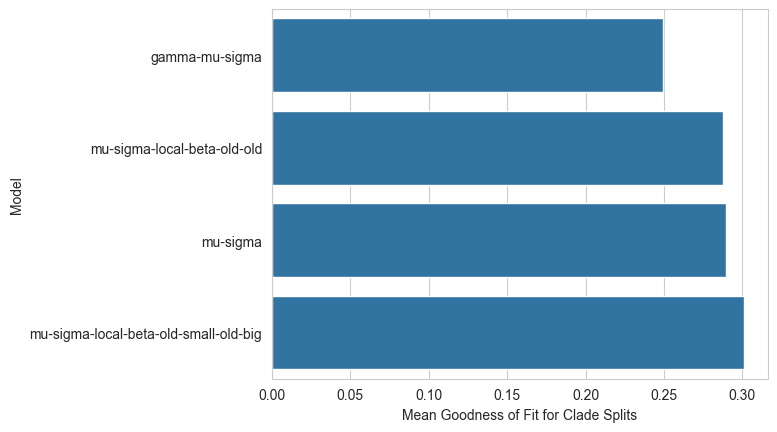

In [96]:
sns.barplot({
    "gamma-mu-sigma": np.mean(sample_gof_4.values),
    "mu-sigma-local-beta-old-old": np.mean(sample_gof_1.values),
    "mu-sigma": np.mean(sample_gof_2.values),
    "mu-sigma-local-beta-old-small-old-big": np.mean(sample_gof_3.values),
}, orient="y")
plt.xlabel("Mean Goodness of Fit for Clade Splits")
plt.ylabel("Model")

In [97]:
difference = sample_gof_1.to_frame().join(sample_gof_2.to_frame(), lsuffix="-mu-sigma", rsuffix="-mu-sigma-beta", how="inner")
difference["difference"] = difference["0-mu-sigma"] - difference["0-mu-sigma-beta"]

In [98]:
difference.mean()

0-mu-sigma         0.261774
0-mu-sigma-beta    0.266062
difference        -0.004288
dtype: float64

In [99]:
difference

,0-mu-sigma,0-mu-sigma-beta,difference
clade_split,,,
0000000001||0000000010,0.060405,0.027598,0.032807
0000000001||0000000100,0.036529,0.037015,-0.000486
0000000001||0000000110,0.089507,0.080679,0.008828
0000000011||0000000100,0.059265,0.085693,-0.026428
0000000100||0000000010,0.017968,0.037386,-0.019418
...,...,...,...
1111100111||0000011000,0.428571,0.350000,0.078571
1111101000||0000010000,0.107646,0.125605,-0.017959
1111101111||0000010000,0.098780,0.107666,-0.008886


In [100]:
sample_gof_2.mean()

np.float64(0.2898765657711332)

<Axes: xlabel='difference', ylabel='Count'>

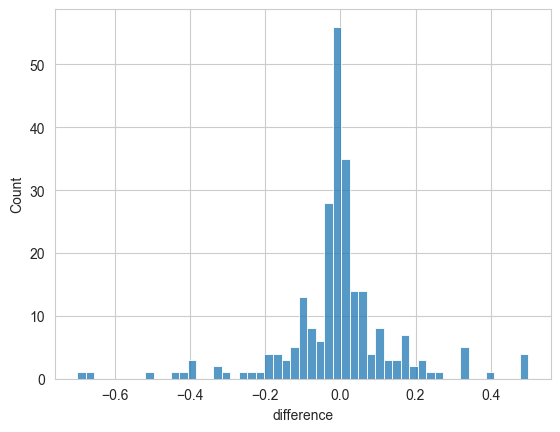

In [101]:
sns.histplot(difference.difference)

In [102]:
difference[difference.difference < 0].sort_values("difference")

,0-mu-sigma,0-mu-sigma-beta,difference
clade_split,,,
0000010000||1110000000,0.200000,0.900000,-0.700000
1110000111||0000010000,0.333333,1.000000,-0.666667
0110010111||1000001000,0.500000,1.000000,-0.500000
0110000111||0001100000,0.285714,0.714286,-0.428571
0001101000||1110000000,0.285714,0.700000,-0.414286
...,...,...,...
0000010000||1000000000,0.028316,0.029853,-0.001537
1001101000||0110000000,0.170130,0.171429,-0.001299
0111100000||1000001000,0.169935,0.171123,-0.001188


In [103]:
difference[difference.index == "0000011111||1001100000"]

,0-mu-sigma,0-mu-sigma-beta,difference
clade_split,,,
0000011111||1001100000,0.345455,0.418182,-0.072727


In [104]:
len(sample_branches_1[sample_branches_1.clade_split == "0000011111||1001100000"])

10